<h1><center>Anomaly Detection su Serie Temporali</h1></center>
<h3><center>Usando Machine Learning (Deep Learning)</h3></center>

(1)

## Cosa sentirete:
- Descrizione di un esempio di problema concreto che ci ha dato il SOC;


- Come viene attualmente indirizzato dal SOC e i problemi che presenta (troppi falsi positivi);


- Una prima soluzione che abbiamo proposto come modifica dell asoluzione attuale (che si sperava mettere subito in campo e invece no);


- Una soluzione al problema usando il Machine Learning "classico". In particolare la tecnica del _boosted decision trees_;


- Una soluzione usando una rete neurale convoluzionale (Convolutional NN) semplice;


- Una soluzione usando una rete che rappresenta lo stato dell'arte _WaveNet_;

## Cosa non sentirete:
Un tutorial sulle reti neurali.

Ci sono già ottimi tutorial e articoli sull'argomento e non ha senso rifare le cose che sarebbero di qualità inferiore.

Invece l'obiettivo è passare il messaggio che:
- il ML è la strada giusta per estrarre info utili dai dati. Non solo statistiche riassuntive e aggregazioni, ma estrarre del valore dai dati tramite il learning.
- il secondo messaggio è che i tool di ML sono alla portata di tutti. Io non conoscevo Python e questi argomenti fino a un anno e mezzo fa. Con un po' di buona volontà sono argomenti affrontabili

Il formato dela presentazione è il Jupyter Notebook che permette di inserire celle con codice, testo, formule LaTeX, e persino di dare un aspetto di presentazione a slides.

Si parte

Questo è il codice iniziale che importa i vari package di cui ho bisogno.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.rcParams['figure.figsize'] = (20, 10)
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 100

from IPython.display import Image
from IPython.core.display import HTML 

Importiamo i dati

In [3]:
df = pd.read_csv('BITRATE_contatori_grezzi.csv', \
                 parse_dates=True, index_col='datetime')
df = df[df.s5ApnDownlinkBytes < 1e13]
df = df.sort_index()
df.head(2)
df.tail(2) 

,SRVREG,GGSN_J20,GGSN_J20_APN,ggsnApnDownlinkBytes-s5ApnDownlinkBytes,s5ApnDownlinkBytes,ggsnApnActivePdpContextCount,pgwApnActiveEpsBearer,pgwApnAttemptedEpsBearerActivation,ggsnApnAttemptedActivation
datetime,,,,,,,,,
2016-09-01,LO,QGGSMI013,ibox.tim.it,3.165439e+11,9.920130e+10,77554.0,30211.0,725.0,28401.0
2016-09-01,LA,QGGSRM013,wap.tim.it,3.033203e+11,3.358968e+11,320474.0,282217.0,13549.0,56050.0


,SRVREG,GGSN_J20,GGSN_J20_APN,ggsnApnDownlinkBytes-s5ApnDownlinkBytes,s5ApnDownlinkBytes,ggsnApnActivePdpContextCount,pgwApnActiveEpsBearer,pgwApnAttemptedEpsBearerActivation,ggsnApnAttemptedActivation
datetime,,,,,,,,,
2017-02-28 11:45:00,LA,QGGSRM013,wap.tim.it,3.785300e+11,6.474063e+11,432221.0,496745.0,31893.0,77964.0
2017-02-28 11:45:00,VE,QGGSVE005,wap.tim.it,5.935220e+10,1.202995e+11,98829.0,127288.0,3.0,5.0


Rinomino i campi in modo più umanamente leggibile.

In [4]:
df = df.rename(columns={'SRVREG':'location', 'GGSN_J20':'name',\
        'GGSN_J20_APN':'apn', 'ggsnApnDownlinkBytes-s5ApnDownlinkBytes':'download3G',\
        's5ApnDownlinkBytes':'download4G', 'ggsnApnActivePdpContextCount':'sessions3G',\
        'pgwApnActiveEpsBearer':'sessions4G', 'ggsnApnAttemptedActivation':'attempted3G',\
        'pgwApnAttemptedEpsBearerActivation':'attempted4G'})
df.tail(2)

,location,name,apn,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G
datetime,,,,,,,,,
2017-02-28 11:45:00,LA,QGGSRM013,wap.tim.it,3.785300e+11,6.474063e+11,432221.0,496745.0,31893.0,77964.0
2017-02-28 11:45:00,VE,QGGSVE005,wap.tim.it,5.935220e+10,1.202995e+11,98829.0,127288.0,3.0,5.0


Abbiamo di fronte una serie temporale _multivariata_, con un campionamento a *15 minuti* e abbiamo uno storico di circa 6 mesi.
Ci sono 3 contatori per il 3G e analoghi per il 4G:

1. Volume totale download utenti su un APN (**download**)
2. Numero di utenti connessi all'APN (**sessions**)
3. Numero di tentativi di nuove sessioni (**attempted**).

In [5]:
df.describe()
df['location'].unique()
df['apn'].value_counts()

,download3G,download4G,sessions3G,sessions4G,attempted4G,attempted3G
count,2.391140e+05,2.391140e+05,239114.000000,239114.000000,2.391140e+05,2.391140e+05
mean,2.397303e+11,2.476518e+11,190494.732274,200827.791551,8.662337e+03,3.408624e+04
std,1.693802e+11,2.478477e+11,162019.788646,204646.149190,2.497991e+04,1.360663e+05
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,6.774016e+10,6.190362e+10,69110.250000,41909.000000,1.229000e+03,1.540200e+04
50%,2.490298e+11,1.651648e+11,96291.500000,61577.500000,2.756500e+03,2.415200e+04
75%,3.798627e+11,3.770917e+11,347838.500000,392288.000000,1.310000e+04,5.513050e+04
max,7.545189e+11,1.563244e+12,658461.000000,826586.000000,1.070692e+07,6.523799e+07


array(['LO', 'LA', 'VE', 'ER', 'SI', 'CB'], dtype=object)

ibox.tim.it       119558
wap.tim.it        106226
waptest.tim.it     13330
Name: apn, dtype: int64

# Anomalie (outliers) in Serie Temporali

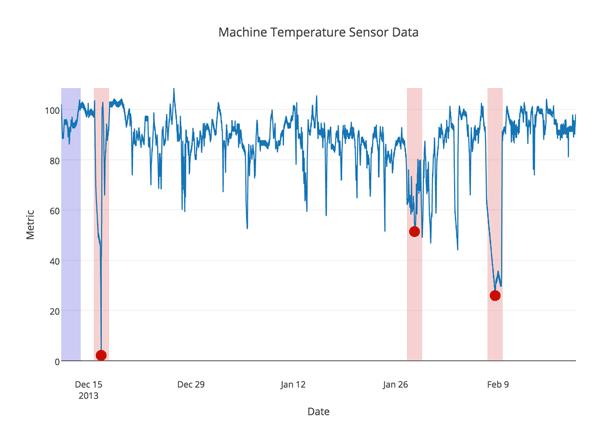

In [6]:
width_size = 1000
Image('pics/anomaly_additive.png', width=width_size)

Il metodo usato dal SOC è una variante dell'**Exponential Smoothing**

Si mantiene uno stato noto come **Profilo** che condensa la storia delle osservazioni passate e viene via via aggiornato con una formula

$$ NewProfile = \alpha \cdot NewObservations + (1 - \alpha) \cdot CurrentProfile $$

dove $\alpha \in (0, 1)$

Dopo di ché, ogni osservazione che è "troppo diversa" dal profilo viene considerata un'anomalia e solleva un allarme.

L'_Esponential Smoothing_ è un approccio semplice (analogo a ARIMA, GARCH) che prevede di lavorare con serie temporali univariate.

Siccome abbiamo una serie multivariata, la trasformiamo in univariata mettendo i contatori in relazione lineare tra loro in qualche modo.

Nel SOC hanno definito il KPI _MeanUserBitrate_, download medio per utente, 

$$ MeanUserBitrate = \frac{TotalDownload} {NumSessions} $$

La formulazione del SOC attuale è:

- Mantiene un profilo della durata di una settimana (si assume un pattern tipico settimanale);
- Ogni osservazione del KPI _MeanUserBitrate_ per ciascun intervallo dei 15 minuti è confrontato col rispettivo del profilo. es. _sabato, 15:00-15:15_;
- Se l'osservazione corrente si scosta del 20% sotto il profilo atteso, si solleva l'allarme;
- Si aggiorna il profilo con l'exponential smoothing solo se l'osservazione corrente non si scosta del 50% dal profilo. Altrimenti il profilo non cambia.

Ora restringiamo l'analisi ad esempio al Veneto (VE) e l'APN ibox e inseriamo una nuova colonna col KPI **LTEmeanUserBitrate** del SOC.

In [7]:
# keep only VE with ibox
dff = df[(df.location == 'VE') & (df.apn == 'ibox.tim.it')]
print('num records:', len(dff)) 

# keep only the 3 columns representing the counters
dff = dff[['download4G', 'sessions4G', 'attempted4G']] 

# drop some big outliers (just 3 values)
dff = dff[dff.download4G < 1e13]
 
# compute the KPI  
dff['LTEmeanUserBitrate'] = dff.download4G / dff.sessions4G * 8 / 900
dff.head()

num records: 16304


,download4G,sessions4G,attempted4G,LTEmeanUserBitrate
datetime,,,,
2016-09-01 00:00:00,1.538978e+11,40834.0,1112.0,33501.017071
2016-09-01 00:15:00,1.305972e+11,40383.0,969.0,28746.345695
2016-09-01 00:30:00,1.165111e+11,40085.0,955.0,25836.458687
2016-09-01 00:45:00,1.042902e+11,39692.0,1395.0,23355.443372
2016-09-01 01:00:00,8.518717e+10,38463.0,13895.0,19686.954086


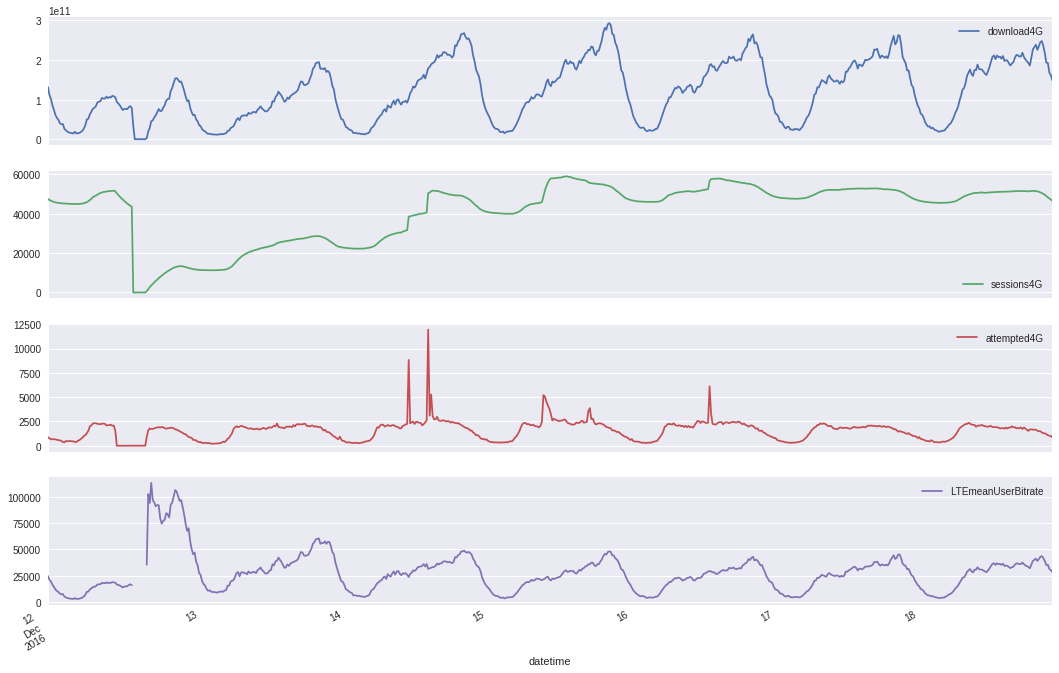

In [8]:
_ = dff.loc['2016-12-12':'2016-12-18'].plot(subplots=True, figsize=(18,12))

Questo è il codice che calcola il profilo come usato dal SOC.

In [9]:
alpha = 0.25

dff['ProfileValue'] = dff['LTEmeanUserBitrate']
dff['Alarm'] = 0

for row in dff.itertuples(name='SOC'):

    current = row.Index
    week_lag = current - pd.Timedelta(days=7)
    try:
        pv = dff.loc[week_lag, 'ProfileValue']
        cv = row.LTEmeanUserBitrate
        
        if (pv - cv) / pv > 0.2 and row.attempted4G > 200:
            _ = dff.set_value(current, 'Alarm', 1)
        
        if np.abs(pv - cv) / max(pv, cv) < 0.5:
            pv = alpha * cv + (1 - alpha) * pv

        _ = dff.set_value(current, 'ProfileValue', pv)

    except KeyError:
        #print('NaN at %s' % week_lag)
        pass

# rule of 3 consecutive violations for an alarm
dff['Alarm3times'] = dff.Alarm * dff.Alarm.shift(-1) * dff.Alarm.shift(-2)
# rule that mark the alarm only once
dff['AlarmOnce'] = dff['Alarm3times'].diff() == -1
print('total alarms:', dff['AlarmOnce'].sum())

total alarms: 54


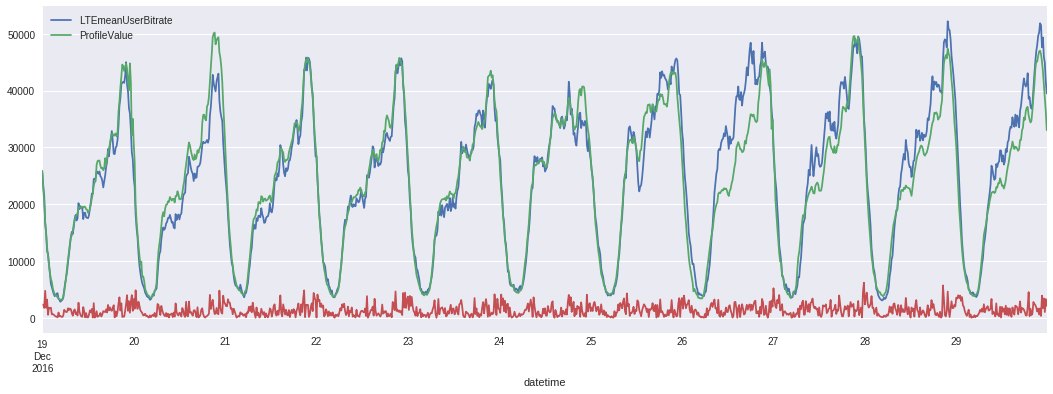

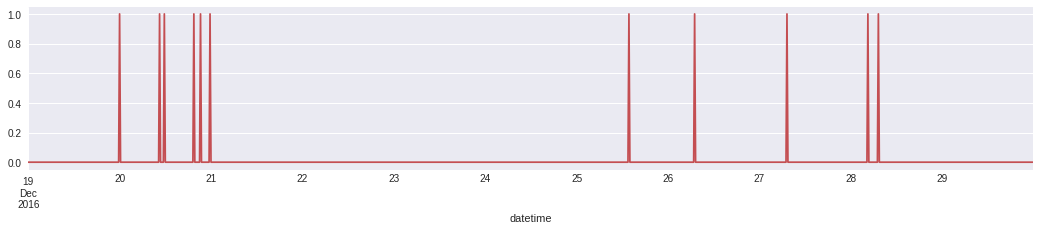

In [10]:
_ = dff.loc['2016-12-19':'2016-12-29', ('LTEmeanUserBitrate', 'ProfileValue')].plot(figsize=(18,6))
_ = dff.loc['2016-12-19':'2016-12-29', 'LTEmeanUserBitrate'].diff().abs().plot()
_ = plt.figure()
_ = dff.loc['2016-12-19':'2016-12-29', 'AlarmOnce'].plot(figsize=(18,3), color='r')

## Troppissimi falsi allarmi

Il problema della soluzione attuale è che assume una serie temporale in cui la varianza è costante (_omoschedastica_).

In realtà si può vedere facilemente che la varianza non è costante (_eteroschedastica_). È maggiore in corrispondenza dei punte delle curve dove ci sono salite e discese repentine (valore assoluto derivata prima alta).

La segnalazione di anomalia, è sì una misura di scostamento dal valore atteso, ma il grado di scostamento si misura in numero di deviazioni standard dal valor medio

Quindi la prima "pezza" è stata di mantenere non solo un profilo del valor medio ma anche della varianza (deviazione standard) e di misuare lo scostamento dalla normalità sulla base della deviazione standard tipica di ciscun intervallo della giornata.

La seconda pezza è stato il modo di trattare l'aggiornamento del profilo quando ci sono gli outliers.

Invece di buttarli, vanno "tagliati" a delle soglie in modo da trasformarli in inliers e poi aggiornare comunque il profilo.

In [11]:
dff['LTEmeanUserBitrate_median'] = dff['LTEmeanUserBitrate'].rolling('1H').median()
dff['LTEmeanUserBitrate_deviation'] = dff['LTEmeanUserBitrate'].rolling('90min').std()
dff.ix[0, 'LTEmeanUserBitrate_deviation'] = dff.ix[1].LTEmeanUserBitrate_deviation

def huber(x, k=3):
    return np.min(np.abs(x), k) * np.sign(x)

def biweight(x, k=3):
    if np.abs(x) >= k: return 4.12
    return 4.12 * (1 - (1 - (x/k)**2) **3)

k = 4.5 # number of std to consider outiliers
alpha = 0.5
omega = 0.1

dff['Profile_expected'] = dff['LTEmeanUserBitrate_median']
dff['Profile_deviation'] = dff['LTEmeanUserBitrate_deviation']
dff['Alarm'] = 0

for i, row in enumerate(dff.itertuples(name='SOC')):

    current = row.Index
    day_lag = current - pd.Timedelta(days=7)
    try:
        pv_mu = dff.loc[day_lag, 'Profile_expected']
        pv_sigma = dff.loc[day_lag, 'Profile_deviation']
        cv_mu = row.LTEmeanUserBitrate_median
        cv_sigma = row.LTEmeanUserBitrate_deviation
        
        if np.isnan(pv_mu): pv_mu = cv_mu
        if np.isnan(pv_sigma): pv_sigma = cv_sigma
        if np.isnan(cv_mu) or np.isinf(cv_mu): cv_mu = pv_mu
        if np.isnan(cv_sigma) or np.isinf(cv_sigma): cv_sigma = pv_sigma
        
        pv_sigma = np.maximum(pv_sigma, 1e-6)
        pv_sigma2 = np.square(pv_sigma)
        new_sigma2 = omega * pv_sigma2 * biweight((cv_mu - pv_mu) / pv_sigma, k) + (1 - omega) * pv_sigma2
        pv_sigma = np.sqrt(new_sigma2)
        
        _ = dff.set_value(current, 'Profile_deviation', pv_sigma)
        
        if np.abs(cv_mu - pv_mu) > k * pv_sigma:
            # this is an outliler, raise alarm only if lower than expected
            if cv_mu < pv_mu and row.attempted4G > 200:
                _ = dff.set_value(current, 'Alarm', 1)
            
            # cut the outlier with Huber function
            cv_mu = pv_mu + pv_sigma * k * np.sign(cv_mu - pv_mu)
        
        pv_mu = alpha * cv_mu + (1 - alpha) * pv_mu
        _ = dff.set_value(current, 'Profile_expected', pv_mu)
        

    except KeyError:
        pass

# rule of 3 consecutive violations for an alarm
dff['Alarm3times'] = dff.Alarm * dff.Alarm.shift(-1) * dff.Alarm.shift(-2)

# rule that mark the alarm only once
dff['AlarmOnce'] = dff['Alarm3times'].diff() == -1

print('total alarms:', dff['AlarmOnce'].sum())

total alarms: 9


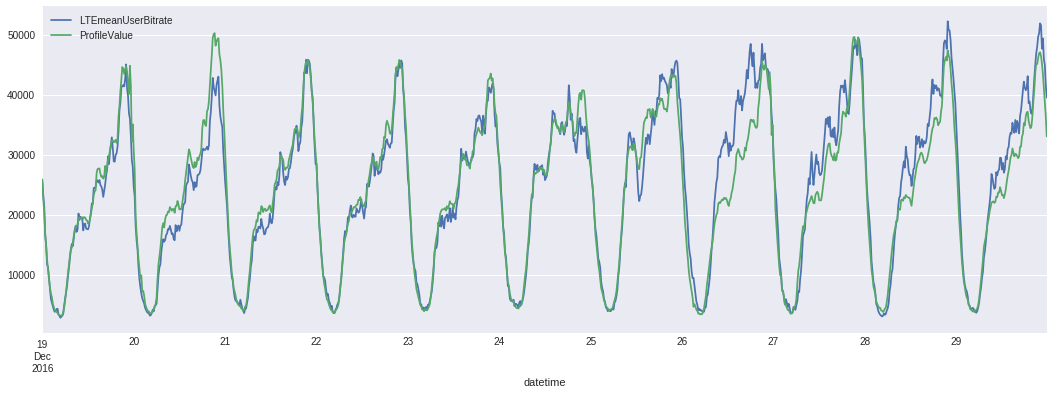

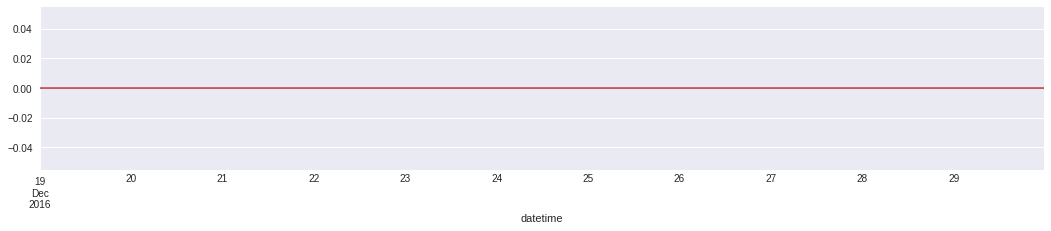

In [12]:
_ = dff.loc['2016-12-19':'2016-12-29', ('LTEmeanUserBitrate', 'ProfileValue')].plot(figsize=(18,6))
_ = plt.figure()
_ = dff.loc['2016-12-19':'2016-12-29', 'AlarmOnce'].plot(figsize=(18,3), color='r')

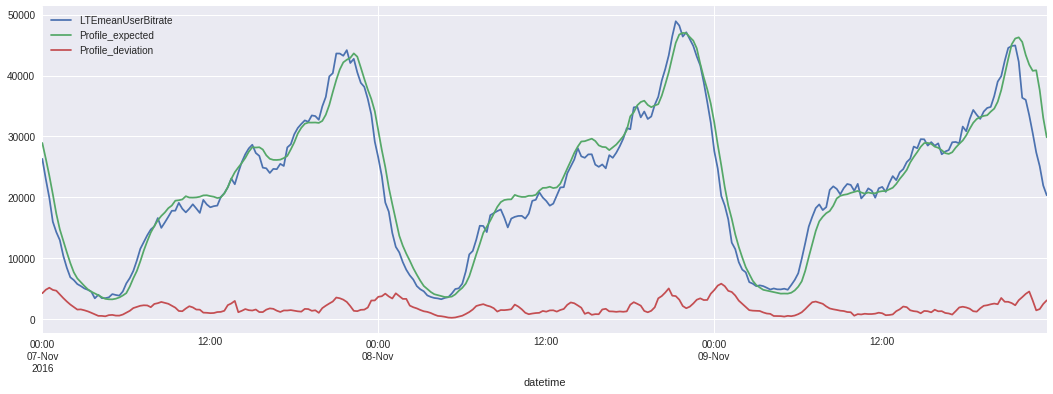

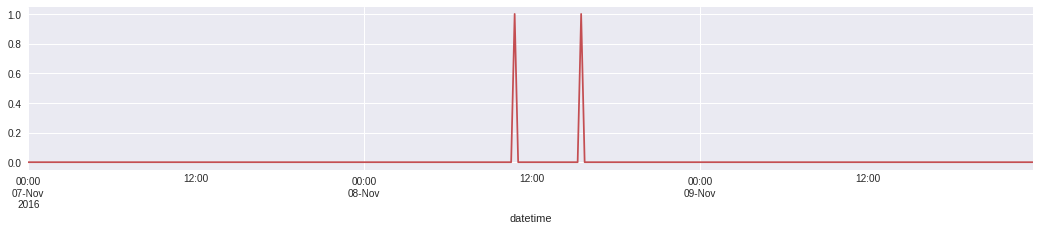

In [13]:
_ = dff.loc['2016-11-07':'2016-11-09', ('LTEmeanUserBitrate', 'Profile_expected', 'Profile_deviation')].plot(figsize=(18,6))
_ = plt.figure()
_ = dff.loc['2016-11-07':'2016-11-09', 'AlarmOnce'].plot(figsize=(18,3), color='r')